In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [23]:
def get_gs(df, tm = 'Tliq', jez=False):
    df['K_W_Tc'] = (df.Tc - df.Tg) / df[tm] # best one in the paper
    df['K_W_Tx'] = (df.Tx - df.Tg) / df[tm]
    df['gamma_Tc'] = df.Tc / (df.Tg+df.Tliq)
    df['H_prime_Tx'] = (df.Tx - df.Tg) / df.Tg
    df['K_H_Tc'] = (df.Tc - df.Tg) / (df[tm] - df.Tc) # replaced Tmelt with Tliq
    df['H_prime_Tc'] = (df.Tc - df.Tg) / df.Tg
    df['K_H_Tx'] = (df.Tx - df.Tg) / (df[tm] - df.Tx) # replaced Tmelt with Tliq
    df['deltaT_rg'] = (df.Tx - df.Tg) / (df.Tliq - df.Tg)
    df['K_cr'] = (df.Tliq - df.Tx) / (df.Tliq - df.Tg)
    if jez:
        df['Jezica'] = (df.ViscosityAtTl) - 2 * np.log10(df.Tliq)
    return df
    
def get_eta_tl(df):
    return df['log10 (η∞)'] + (12-df['log10 (η∞)'])*(df.T12/df.Tliq)*np.exp((df.m/(12-df['log10 (η∞)'])-1)*(df.T12/df.Tliq - 1))
    
def get_gfa(df, logXs = -2, logNs = 3, g=pi, **kw):
    Umax = 10 ** df.log_Umax
    
    tn = (10**logXs / (g * 10**logNs * Umax**2))**(1 / 2)

    df['GFA'] = -np.log10((df.Tliq - df.T_Umax) / tn)
    return df

# Load models and data

In [3]:
glassnet_no_stnn = GlassNet(st_models=[])
glassnet_stnn = GlassNet()

In [4]:
glassnet_test_df = pd.read_csv('glassnet_test_df.csv', index_col=0, header=[0, 1])
glassnet_train_df = pd.read_csv('glassnet_train_df.csv', index_col=0, header=[0, 1])

In [5]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [31]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)
X_glassnet_feats_total, feats = glassnet_stnn.featurizer(X_glassnet_total, return_cols = True)

In [32]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)
X_glassnet_feats_total = pd.DataFrame(X_glassnet_feats_total, columns = feats)

In [33]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index
X_glassnet_feats_total.index = X_glassnet_total.index

In [34]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train['ViscosityAtTl'] = pd.read_csv('glassnet_train_viscosity_at_tl.csv', index_col=0)
y_glassnet_test['ViscosityAtTl'] = pd.read_csv('glassnet_test_viscosity_at_tl.csv', index_col=0)
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

In [35]:
gs_glassnet_train = get_gs(y_glassnet_train )
gs_glassnet_test = get_gs( y_glassnet_test )
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test) )

In [53]:
benchmark_df = pd.read_csv('gfa_benchmarks.csv',sep=";") # Table 2
benchmark_df.rename(columns={'Tg (K)': 'Tg', 'Tx (K)': 'Tx', 'Tc (K)': 'Tc', 'Tl (K)': 'Tliq', 'T(Umax) (K)': 'T_Umax',
                             'Umax (m s−1)': 'Umax'}, inplace=True)
benchmark_df['log10 (η∞)'] = benchmark_df['log10 (η∞)'].str.replace('−', '-').astype('float')
benchmark_titles_temps = [r'$T_g$', r'$T_x$', r'$T_c$', r'$T_l$', r'$T_{Umax}$', r'$T_{12}$']
benchmark_df['ViscosityAtTl'] = get_eta_tl(benchmark_df)
benchmark_df['log_Umax'] = np.log( benchmark_df.Umax.str.replace('E', 'e').str.replace('−', '-').values.astype(float) )
benchmark_glassnet_feats = [ glassnet_stnn.featurizer(comp, return_cols = False)[0] for comp in benchmark_df.Glass ]
benchmark_glassnet_feats = pd.DataFrame( np.vstack( benchmark_glassnet_feats ), columns = feats )

In [19]:
cols = ['Tg', 'Tc', 'Tx', 'Tl', 'T_Umax', 'log_Umax']
titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$', '$T_{max(U)}$', '$log(U_{max})$']

In [24]:
gs_benchmark = get_gs( benchmark_df, jez=True )
gfa_benchmark = get_gfa( benchmark_df)

In [25]:
y_pred_benchmark_glassnet = pd.concat( [ glassnet_stnn.predict(comp) for comp in benchmark_df.Glass ] ).reset_index(drop=True).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})

In [26]:
rf = RandomForestRegressor()
col = ['Tliq']
this_y_train = y_glassnet_train[col].dropna()
this_X_train = X_glassnet_feats_train.loc[ this_y_train.index, : ]
this_y_test = y_glassnet_test[col].dropna()
this_X_test = X_glassnet_feats_test.loc[ this_y_test.index, : ]

rf.fit(this_X_train, this_y_train)

/var/folders/lc/m_z4zy9x62x6ly0p54t47jnh0000gp/T/ipykernel_69281/4195890325.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(this_X_train, this_y_train)


RandomForestRegressor()

In [54]:
y_pred_benchmark_rf = rf.predict( benchmark_glassnet_feats )

In [55]:
y_pred_benchmark_glassnet['ViscosityAtTl'] = [ glassnet_stnn.predict_log10_viscosity(T = y_pred_benchmark_glassnet.loc[i,'Tliq'],
                                                                          composition = comp) for i,comp in enumerate(benchmark_df.Glass) ]

In [58]:
rf_viscosity = [ glassnet_stnn.predict_log10_viscosity(T = y_pred_benchmark_rf[i],
                                                                          composition = comp) for i,comp in enumerate(benchmark_df.Glass) ]

In [59]:
y_pred_benchmark_rf = pd.DataFrame( np.column_stack( (y_pred_benchmark_rf, rf_viscosity) ), columns = ['Tliq', 'ViscosityAtTl'] )

In [93]:
jezica_pred_glassnet = [i[0] for i in (y_pred_benchmark_glassnet.ViscosityAtTl) - 2 * np.log10(y_pred_benchmark_glassnet.Tliq)]
jezica_pred_rf = (y_pred_benchmark_rf.ViscosityAtTl) - 2 * np.log10(y_pred_benchmark_rf.Tliq)

In [62]:
r2_score( gs_benchmark.Jezica, jezica_pred_glassnet )

0.5819902064936009

In [63]:
r2_score( gs_benchmark.Jezica, jezica_pred_rf )

0.7199088949772414

In [65]:
myrcparams = {
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

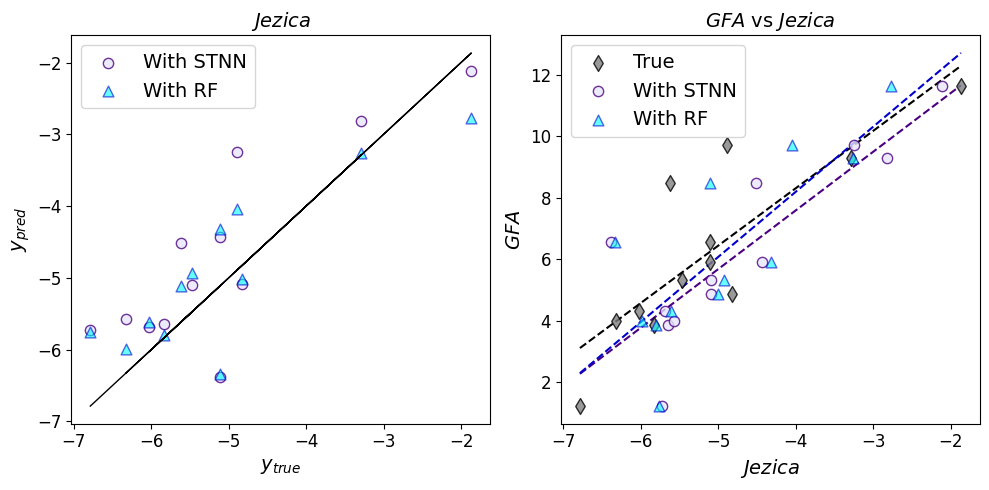

In [105]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].scatter(gs_benchmark.Jezica, jezica_pred_glassnet, marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='With STNN')
ax[0].scatter(gs_benchmark.Jezica, jezica_pred_rf, marker='^', s=60, alpha=0.6, color='cyan', edgecolor='mediumblue', label='With RF')
ax[0].plot(gs_benchmark.Jezica, gs_benchmark.Jezica, color='black',linewidth=1.0)
ax[0].set_xlabel(r'$y_{true}$')
ax[0].set_ylabel(r'$y_{pred}$')
ax[0].set_title('$Jezica$')
ax[0].legend()

m_true, b_true = np.polyfit(gs_benchmark.Jezica.values, gfa_benchmark.GFA.values, 1)
m_glassnet, b_glassnet = np.polyfit(jezica_pred_glassnet, gfa_benchmark.GFA.values, 1)
m_rf, b_rf = np.polyfit(jezica_pred_rf.values, gfa_benchmark.GFA.values, 1)
x = np.linspace( min(gs_benchmark.Jezica), max(gs_benchmark.Jezica), 100)
y_true = m_true*x+b_true
y_glassnet = m_glassnet*x+b_glassnet
y_rf = m_rf*x+b_rf

ax[1].plot(x,y_true,color='black', linestyle='dashed')
ax[1].plot(x,y_glassnet,color='indigo', linestyle='dashed')
ax[1].plot(x,y_rf,color='mediumblue', linestyle='dashed')
ax[1].scatter(gs_benchmark.Jezica, gfa_benchmark.GFA, marker='d', s=65, alpha=0.8, color='gray', edgecolor='black', label='True', zorder=3 )
ax[1].scatter(jezica_pred_glassnet, gfa_benchmark.GFA, marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='With STNN', zorder=3)
ax[1].scatter(jezica_pred_rf, gfa_benchmark.GFA, marker='^', s=60, alpha=0.6, color='cyan', edgecolor='mediumblue', label='With RF', zorder=3)
ax[1].set_xlabel(r'$Jezica$')
ax[1].set_ylabel(r'$GFA$')
ax[1].set_title('$GFA$ vs $Jezica$')
ax[1].legend()
fig.savefig('figures5.png', dpi=600)

In [101]:
print(m_true, m_glassnet, m_rf)

1.868982801705517 1.9108775052911373 2.1202943608939897


In [102]:
kendalltau( gs_benchmark.Jezica, gfa_benchmark.GFA )

SignificanceResult(statistic=0.6666666666666666, pvalue=0.0018032758136924804)

In [103]:
kendalltau( jezica_pred_glassnet, gfa_benchmark.GFA )

SignificanceResult(statistic=0.6363636363636362, pvalue=0.003181646992410881)

In [104]:
kendalltau( jezica_pred_rf, gfa_benchmark.GFA )

SignificanceResult(statistic=0.5757575757575757, pvalue=0.008757732750788306)